<a href="https://colab.research.google.com/github/cbsobral/ml-fies/blob/main/Module02a_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module 02a - ANN

In this module, we perform the following steps:

1. Load the data from Mod_00 and create sets and targets for train and test datasets;
2. Create under and over samples from the original train set;
3. Perform grid search for all of them;
4. Calculate performance measures. 

### 1 - Load Data

Here, we import the training and testing sets created in Module00_Data. 


In [20]:
import pandas as pd

url_train = "https://drive.google.com/file/d/1IP7jyXkLgD_Ouy5cL6fJk4VUA5qRB2PK/view?usp=sharing"
path_train = "https://drive.google.com/uc?export=download&id="+url_train.split("/")[-2]
train = pd.read_csv(path_train)
train.shape

(351001, 31)

In [21]:
url_test = "https://drive.google.com/file/d/1v4FqKwt7NzG5RM6d9f1y7CLIdKq69jSS/view?usp=sharing"
path_test = "https://drive.google.com/uc?export=download&id="+url_test.split("/")[-2]
test = pd.read_csv(path_test)
test.shape

(87751, 31)

In [22]:
train_set = train.drop("default", axis=1) # drop targets for training set
train_target = train["default"].copy()

In [23]:
test_set = test.drop("default", axis=1) # drop targets for test set
test_target = test["default"].copy()

### 2 - Pipeline

The pipeline contains functions that will be used to transform the dataset. For the numeric attributes, the stardardization is performed by the StandardScaler. For ordinal attributes, variables are encoded by the OrdinalEncoder, and for categorical, theOneHotEncoder. 

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("num_imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ])

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

ord_pipeline = Pipeline([
        ("ord_imputer", SimpleImputer(strategy="most_frequent")),
        ("ord_encoder", OrdinalEncoder()),
    ])

In [26]:
ord_attribs = ["igc","date_contract"] # 2 attributes

num_attribs = ["family_income",   #17
               "personal_income",
               "high_school_endyear",
               "n_sem_course",
               "n_completed_sem",
               "sem_funded",
               "fam_size",
               "income_pc",
               "tuition_current",
               "inc_prop",
               "perc_requested",
               "loan_value_sem",
               "student_resource",
               "loan_value",
               "loan_limit",
               "total_debt",
               "age"]
  

cat_attribs = ["semester_enroll",  #9
               "gender",
               "occupation", 
               "marital_status",
               "ethnicity", 
               "public_hs", 
               "state_course", 
               "degree", 
               "contract_phase"]

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ("ord", ord_pipeline, ord_attribs)
        ])

In [28]:
train_prepared = full_pipeline.fit_transform(train_set)
train_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [29]:
test_prepared = full_pipeline.fit_transform(test_set)
test_prepared[:1]

<1x94 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

### 3 - Sampling 


In [30]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
data_under, target_under = rus.fit_resample(train_prepared, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [31]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
data_over, target_over = ros.fit_resample(train_prepared, train_target)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### 4 - Hyperparameters

In [29]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000, random_state=42)

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

parameter_grid = {'hidden_layer_sizes': [(sp_randint.rvs(10,50,1),sp_randint.rvs(10,50,1),), 
                                          (sp_randint.rvs(10,50,1),)], # (low, high, size) 
                  'activation': ['tanh', 'relu', 'logistic'],
                  'solver': ['sgd', 'adam', 'lbfgs'],
                  'alpha': [0.0001, 0.05],
                  'learning_rate': ['constant','adaptive']}

grid_search = RandomizedSearchCV(mlp, parameter_grid, n_jobs=-1, n_iter=20, cv=3, scoring = 'roc_auc')

In [ ]:
# perform random grid search on original train set 
grid_original = grid_search.fit(train_prepared, train_target)
grid_original.best_params_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
# perform random grid search on undersample train set
grid_under = grid_search.fit(data_under, target_under)
grid_under.best_params_

In [ ]:
# perform random grid search on oversample train set 
grid_over = grid_search.fit(data_over, target_over)
grid_over.best_params_

In [ ]:
import joblib

joblib.dump(grid_original, "grid_original.joblib", compress=3)
# joblib.dump(grid_under, "grid_under.joblib", compress=3)
# joblib.dump(grid_over, "grid_over.joblib", compress=3)

### 5 - Performance Evaluation

Here, we calculate AUC and Brier scores for the different samples.

#### Load Trained Models

#### Training Set

In [ ]:
from sklearn.model_selection import cross_val_score

auc_train_original = (cross_val_score(grid_original, train_prepared, train_target, cv=2, scoring="roc_auc")).mean()
auc_train_under = (cross_val_score(grid_under, data_under, target_under, cv=2, scoring="roc_auc")).mean()
auc_train_over = (cross_val_score(grid_over, data_over, target_over, cv=2, scoring="roc_auc")).mean()

In [ ]:
# List with AUC scores for training set
auc_models_train = [auc_train_original, auc_train_under, auc_train_over]
auc_names_train = ['Original', 'Undersampled', 'Oversampled']

# Dataframe 
auc_train_df = pd.DataFrame({"Sample": auc_names_train, "AUC": auc_models_train})
auc_train_df.sort_values(by = "AUC", ascending=False)

#### Test Set

In [11]:
import joblib

grid_original = joblib.load('/content/grid_original.joblib')
grid_under = joblib.load('/content/grid_under.joblib')
grid_over = joblib.load('/content/grid_over.joblib')

In [12]:
from sklearn.metrics import roc_auc_score

# predict probabilities for test set
pred_original = grid_original.predict_proba(test_prepared)
pred_under = grid_under.predict_proba(test_prepared)
pred_over = grid_over.predict_proba(test_prepared)

In [13]:
from sklearn.metrics import roc_auc_score

# AUC score
auc_original = roc_auc_score(test_target, pred_original[:,1])
auc_under = roc_auc_score(test_target, pred_under[:,1])
auc_over = roc_auc_score(test_target, pred_over[:,1])

In [14]:
from sklearn.metrics import brier_score_loss

bs_original = brier_score_loss(test_target, pred_original[:,1])
bs_under = brier_score_loss(test_target, pred_under[:,1])
bs_over = brier_score_loss(test_target, pred_over[:,1])

In [15]:
# List with AUC scores
auc_list = [auc_original, auc_under, auc_over]

# List with Brier Scores
bs_list = [bs_original, bs_under, bs_over]

# List with model names
names_list = ['Original', 'Undersample', 'Oversample']

# Dataframe 
auc_df = pd.DataFrame({"Model": names_list, "AUC": auc_list, "BS": bs_list})
auc_df.sort_values(by = "AUC", ascending=False)

,Model,AUC,BS
1,Undersample,0.832157,0.166590
2,Oversample,0.822252,0.171856
0,Original,0.791856,0.180172


The AUC results can be plotted, as shown bellow. 

In [16]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_original, tpr_original, thresh_original = roc_curve(test_target, pred_original[:,1], pos_label=1)
fpr_under, tpr_under, thresh_under = roc_curve(test_target, pred_under[:,1], pos_label=1)
fpr_over, tpr_over, thresh_over = roc_curve(test_target, pred_over[:,1], pos_label=1)


# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_target))]
p_fpr, p_tpr, _ = roc_curve(test_target, random_probs, pos_label=1)

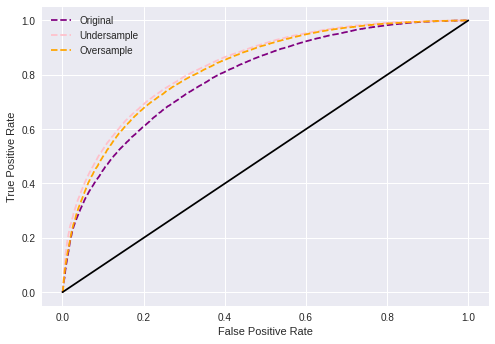

In [17]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

# plot roc curves
plt.plot(fpr_original, tpr_original, linestyle="--",color="purple", label="Original")
plt.plot(fpr_under, tpr_under, linestyle="--",color="pink", label="Undersample")
plt.plot(fpr_over, tpr_over, linestyle="--",color="orange", label="Oversample")
plt.plot(p_fpr, p_tpr, linestyle="-", color="black")

# x label
plt.xlabel("False Positive Rate")
# y label
plt.ylabel("True Positive Rate")

plt.legend(loc="best")
plt.savefig("ROC", dpi = 300)
plt.show()

### 6 - Feature Importance

In [18]:
!pip install eli5

#### 7 - Feature Importance

This routine is necessary to get the feature importance and feature names

In [ ]:
clf = Pipeline(steps=[('preprocessor', full_pipeline),
                      ('classifier', grid_under)])
clf.fit(train_set, train_target)

In [ ]:
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['one_hot'].get_feature_names(input_features=cat_attribs))


In [ ]:
numeric_features_list = list(num_attribs)
numeric_features_list.extend(onehot_columns)
numeric_features_list.extend(ord_attribs)

In [ ]:
import eli5
eli5.explain_weights(clf.named_steps['classifier'], top=100, feature_names=numeric_features_list, feature_filter=lambda x: x != '<BIAS>')